# NE 204 Lab 2 Analysis
## Kalie Knecht
Lab Partners: Ian Kolaja and Trevor Arino

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

# general package imports
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import find_peaks, peak_prominences
from scipy.optimize import curve_fit
from scipy.stats import linregress
from spectrum import gaussian
import pandas as pd

# import tool repo
import sys

# UPDATE PATH TO PATH WHERE YOU HAVE REPO SAVED
sys.path.append('/Users/kalie/courses/ne204/lab/kalieknecht_lab2')
from tools import find_activity, import_data, subtract_baseline
from filters import fit_tau, fit_taus, JordanovFilter, BogovacFilter, CooperFilter
from spectrum import spectrum
from pulse_shape import find_rise_time

## import data

In [2]:
# # function imports data, removes duplicate events, and converts to np.int16
# # type conversion to np.int16 takes some time


print('cs far')
f_name = './data/cs.h5'
f_data = h5py.File(f_name,'r')
cs = f_data['raw_data'][()]
cs_events = f_data['event_data'][()]
print(str(cs.shape[0])+' events')

print('cs close')
f_name = './data/cs_close.h5'
f_data = h5py.File(f_name,'r')
cs_close = f_data['raw_data'][()]
cs_close_events = f_data['event_data'][()]
print(str(cs_close.shape[0])+' events')


# calibration data from last lab - might use, might not
# print('co calibration')
# f_name = './data/co.h5'
# f_data = h5py.File(f_name,'r')
# co = f_data['raw_data'][()]
# co_events = f_data['event_data'][()]
# print(str(co.shape[0])+' events')

# print('ba calibration')
# f_name = './data/ba.h5'
# f_data = h5py.File(f_name,'r')
# ba = f_data['raw_data'][()]
# ba_events = f_data['event_data'][()]
# print(str(ba.shape[0])+' events')

# pulser noise data
# f_name = './data/pulser.h5'
# f_data = h5py.File(f_name,'r')
# noise = f_data['raw_data'][()]
# noise_events = f_data['event_data'][()]
# print(str(noise.shape[0])+' events')

cs far
152057 events
cs close
57069 events


## Calibration source information
* Cs-137
    * 10.2 $\mu$Ci, 377.4 kBq, 1-Jun-13
    * half life: 30.08(9) y (NNDC)
    * source strength on 10/28/22: 8.21 $\mu$Ci
    * Associated gamma-ray energy:
        * 662 keV, 85.10(20) %

In [4]:
# find source activties during measurement
# function syntax (half-life, initial activity, time since born date (in units of half-life))
# function output: activity during measurement in units of initial activity
print('Cs137')
Acs = find_activity(30.09,10.2,9 + 4/12 + 27/365.25)
print('10/28: ',Acs)

Cs137
10/28:  8.212719257704487


## Plot raw waveforms
From plotting we can see some additional cleanup is necessary

In [3]:
# convert waveform time scale to nanoseconds
wave_times = np.linspace(0,1/(250*10**6)*50000*10**9,50000)

<IPython.core.display.Javascript object>


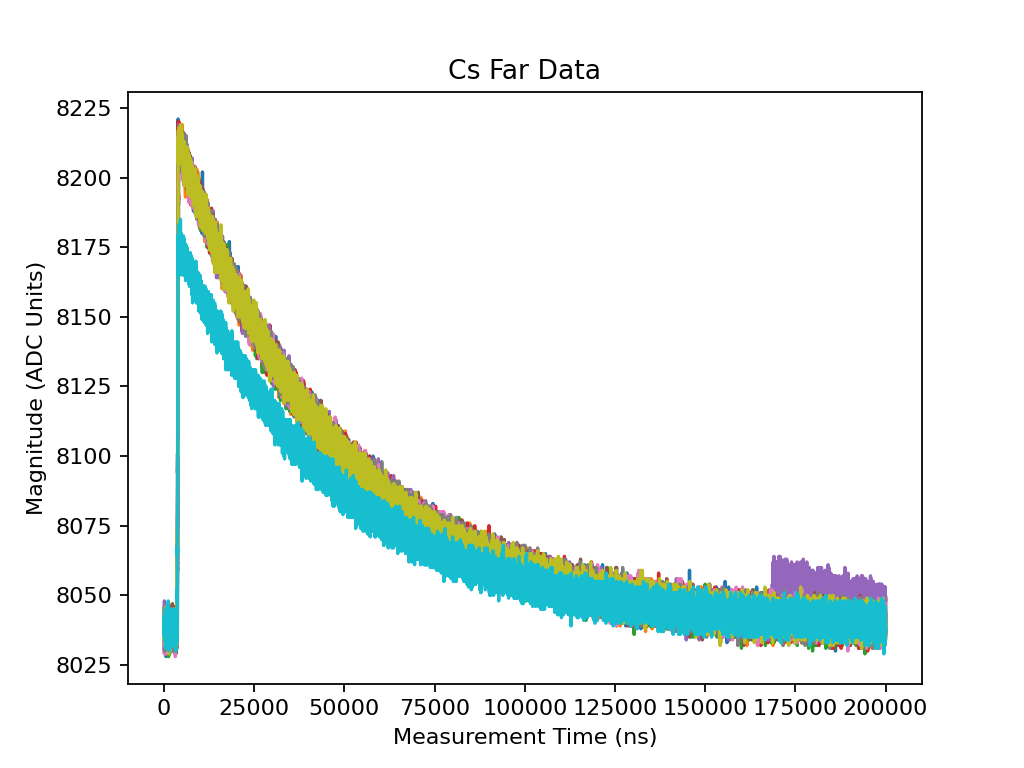

In [4]:
# plot random pulses
# number of random pulses
number_of_pulses = 10
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(cs))
    plt.plot(wave_times,cs[n])
#plt.xlim(920,1150)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (ADC Units)')
plt.title('Cs Far Data')
plt.show()

<IPython.core.display.Javascript object>


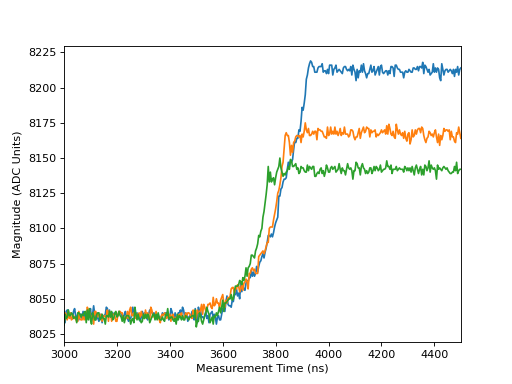

In [5]:
# plot random pulses
# number of random pulses
number_of_pulses = 3
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(cs))
    plt.plot(wave_times,cs[n])
plt.xlim(3000,4500)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (ADC Units)')
# plt.title('Cs Far Da')
# plt.savefig('figs/diff_pulse_shapes.png')
plt.show()

<IPython.core.display.Javascript object>


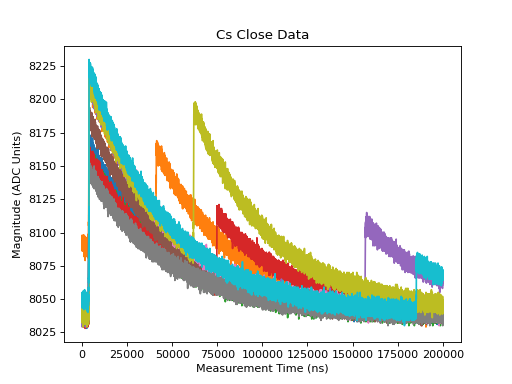

In [6]:
# plot random pulses
# number of random pulses
number_of_pulses = 10
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(cs_close))
    plt.plot(wave_times,cs_close[n])
#plt.xlim(920,1150)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (ADC Units)')
plt.title('Cs Close Data')
plt.show()

<IPython.core.display.Javascript object>


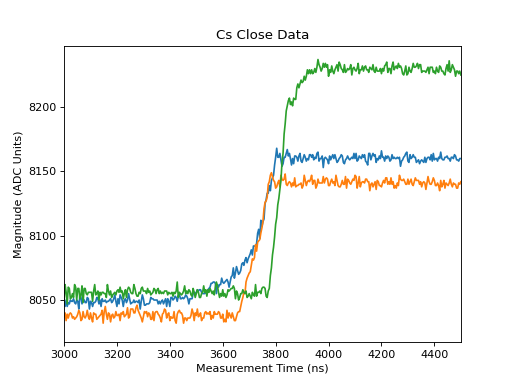

In [7]:
# plot random pulses
# number of random pulses
number_of_pulses = 3
plt.figure()
for i in range(number_of_pulses):
    n = int(np.random.rand()*len(cs_close))
    plt.plot(wave_times,cs_close[n])
plt.xlim(3000,4500)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (ADC Units)')
plt.title('Cs Close Data')
plt.show()

# Lab 2 requirements
Digitized preamplifier voltage signals are used as the basis for determining the position of interaction of a gamma ray relative to the electrodes of a semiconductor detector. Pulse shape analysis techniques for de-convolving multiple gamma-ray interactions will be investigated. The application of event-selection filters will be evaluated in terms of the overall spectral response, including the peak-to-Compton (PC) and peak-to-total (PT) ratios. In addition, the trade-offs between pulse pile-up and optimal SNR performance will be evaluated for high-rate gamma-ray spectroscopy.


Develop techniques to correlate the interaction history of individual gamma rays in the detector to the corresponding preamplifier signal. Consider parameterizing the time profile of the rising edge of the signal in terms of fractions of total induced charge. For example, the rise-time of a signal is usually defined as the time it takes for the signal to rise from 10% of maximum to 90% of maximum, or trise = t90 - t10. Create energy spectra using only signals within various ranges of rise time: comment on variations in the PC and PT ratios. Given these correlations (if any), can you devise a simple gamma-ray event-selection filter to improve the PC ratio?

Required: 
* Devise an event selection filter based on signal shape and quantitatively evaluate its effect on gamma-ray energy spectra in terms of total counts and PC ratio. Provide a theoretical justification for the event selection procedure you are proposing.
* Evaluate and compare multiple event selection filters and quantify their impact on gamma-ray spectra.
* Identify multiple-site interaction events and justify your selection process.
* Using a strong gamma-ray source, evaluate the trade-offs between energy resolution and pile-up (or throughput) for triangular/trapezoidal shaping filters with various peaking & gap times.


Optional:
* Use the Shockley-Ramo theorem and conventional electrostatics to predict the signal shape for gamma-ray interaction positions with in the detector. Using a collimated gamma-ray source, experimentally validate your predicted signal shape. 

In [5]:
# downsample data so filters can handle it
# maybe your computer is better than mine and you can remove the downsampling
cs_down = cs[::10]
print(len(cs_down))
cs_close_down = cs_close[::4]
print(len(cs_close_down))

15206
14268


In [190]:
# get rise times

In [6]:
far_rise_times = np.zeros(len(cs_down))
for i in range(len(cs_down)):
    far_rise_times[i] = find_rise_time(cs_down[i])

In [7]:
close_rise_times = np.zeros(len(cs_close_down))
for i in range(len(cs_close_down)):
    close_rise_times[i] = find_rise_time(cs_close_down[i])

<IPython.core.display.Javascript object>


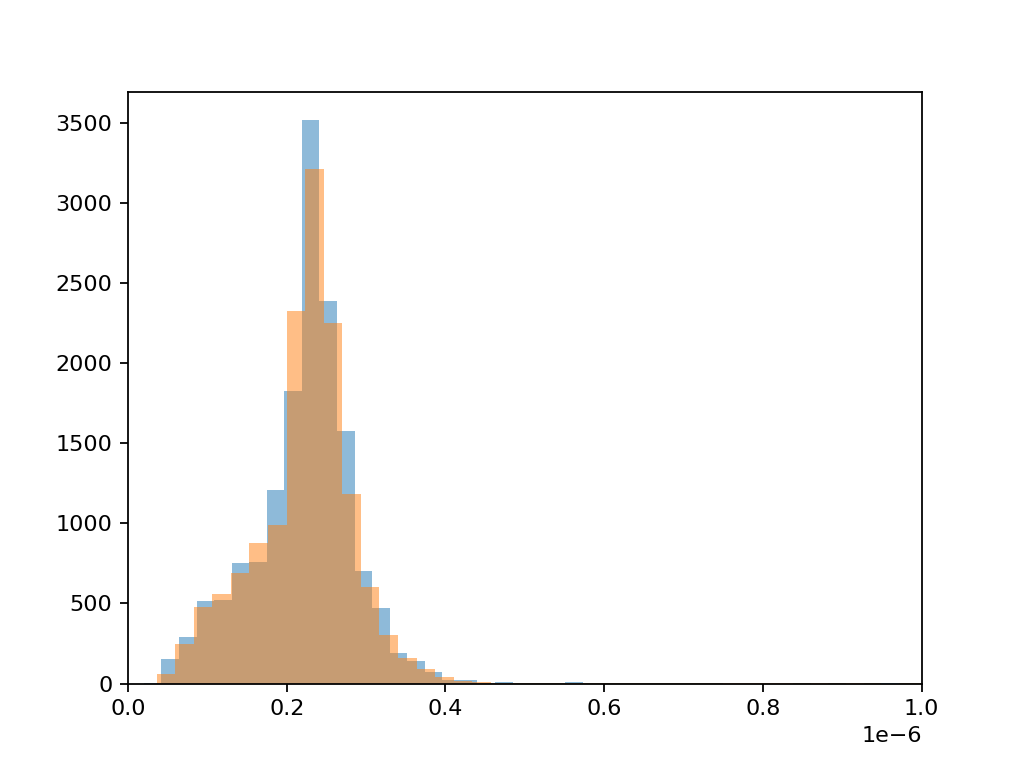

In [8]:
hist_bins=100
plt.figure()
plt.hist(far_rise_times,bins=hist_bins,alpha=0.5)
plt.hist(close_rise_times,bins=hist_bins,alpha=0.5)
plt.xlim(0,1e-6)
plt.show()

# apply trapezoidal filter to raw waveform

In [9]:
# Use same filter parameters as lab 1
tau = 10967.425786005182
tau = tau * 4 * 10**(-9)
peaking_time = 100 * 4 * 10**(-9)
gap_time = peaking_time * 5  

print('Filter parameters:')
print('tau =',tau)
print('peaking time = ', peaking_time)
print('gap time = ', gap_time)

Filter parameters:
tau = 4.3869703144020734e-05
peaking time =  4.0000000000000003e-07
gap time =  2.0000000000000003e-06


In [10]:
Cooper_filter = CooperFilter(peaking_time, gap_time, tau)

In [11]:
filtered_cs = Cooper_filter.filter_waveform(cs_down,normalize=True)

In [12]:
filtered_cs_close = Cooper_filter.filter_waveform(cs_close_down,normalize=True)

In [20]:
all_filtered_waveforms = np.concatenate((filtered_cs,filtered_cs_close),axis=0)

<IPython.core.display.Javascript object>


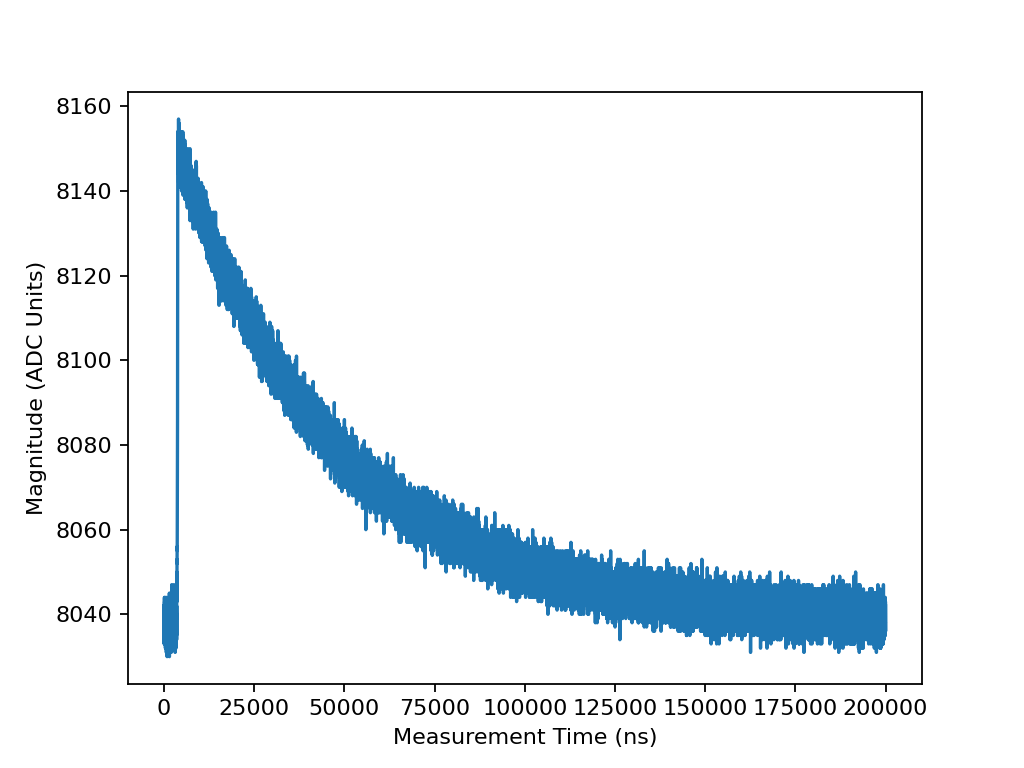

In [12]:
pulse_num = 10
plt.figure()
plt.plot(wave_times,cs_down[pulse_num])
plt.ylabel('Magnitude (ADC Units)')
plt.xlabel('Measurement Time (ns)')
#plt.title('Raw Waveform')
plt.savefig('figs/example_pulse_raw.png')
plt.show()

<IPython.core.display.Javascript object>


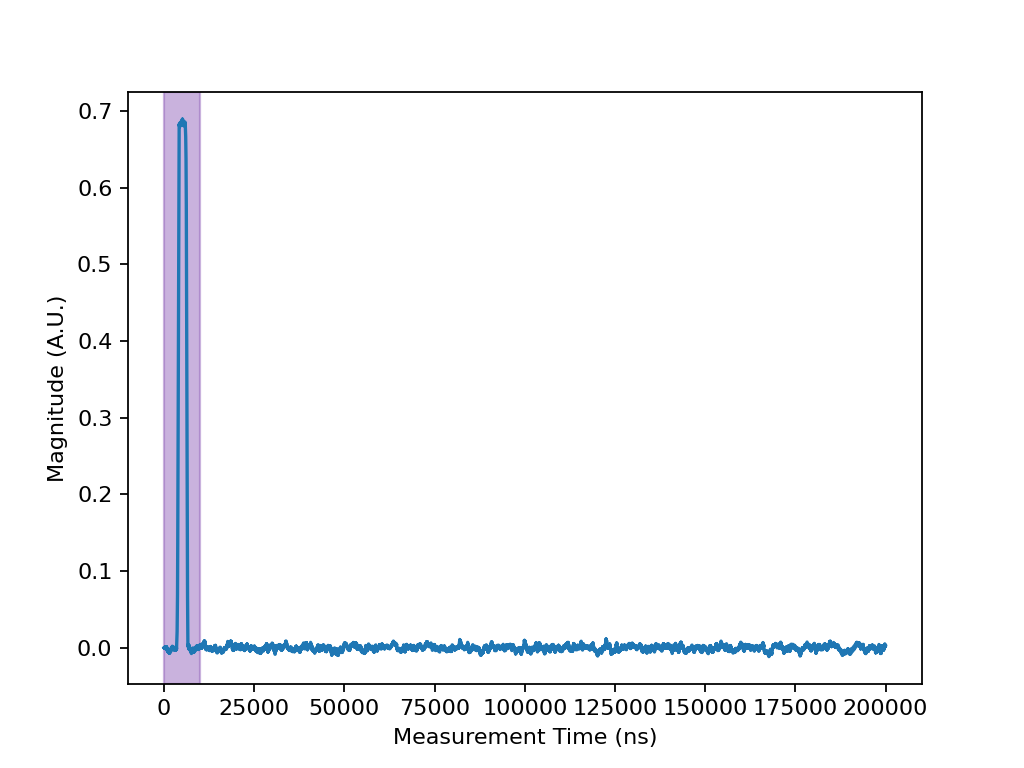

In [13]:
plt.figure()
plt.plot(wave_times,filtered_cs[pulse_num])
plt.axvspan(0,10000,color='tab:purple',alpha=0.5)
plt.ylabel('Magnitude (A.U.)')
plt.xlabel('Measurement Time (ns)')
#plt.title('Filtered Waveform')
plt.savefig('figs/example_pulse_filtered.png')
plt.show()

<IPython.core.display.Javascript object>


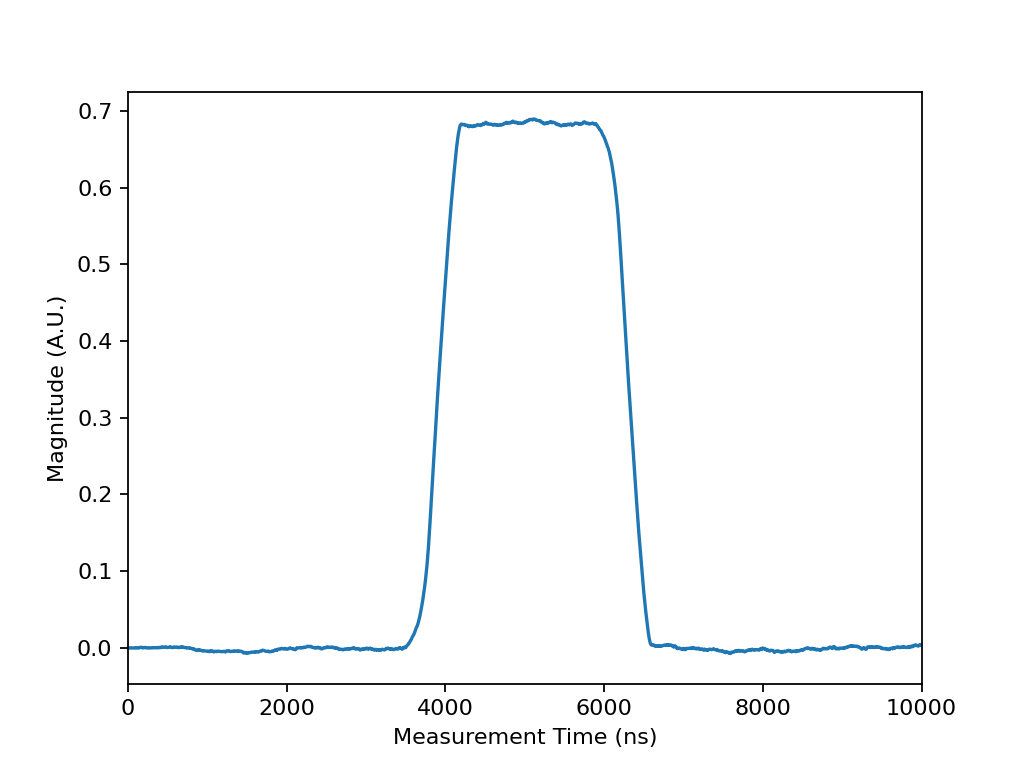

In [15]:
plt.figure()
plt.plot(wave_times,filtered_cs[pulse_num])
plt.xlim(0,10000)
plt.ylabel('Magnitude (A.U.)')
plt.xlabel('Measurement Time (ns)')
plt.savefig('figs/example_pulse_filtered_zoomed.png')
plt.show()

<IPython.core.display.Javascript object>


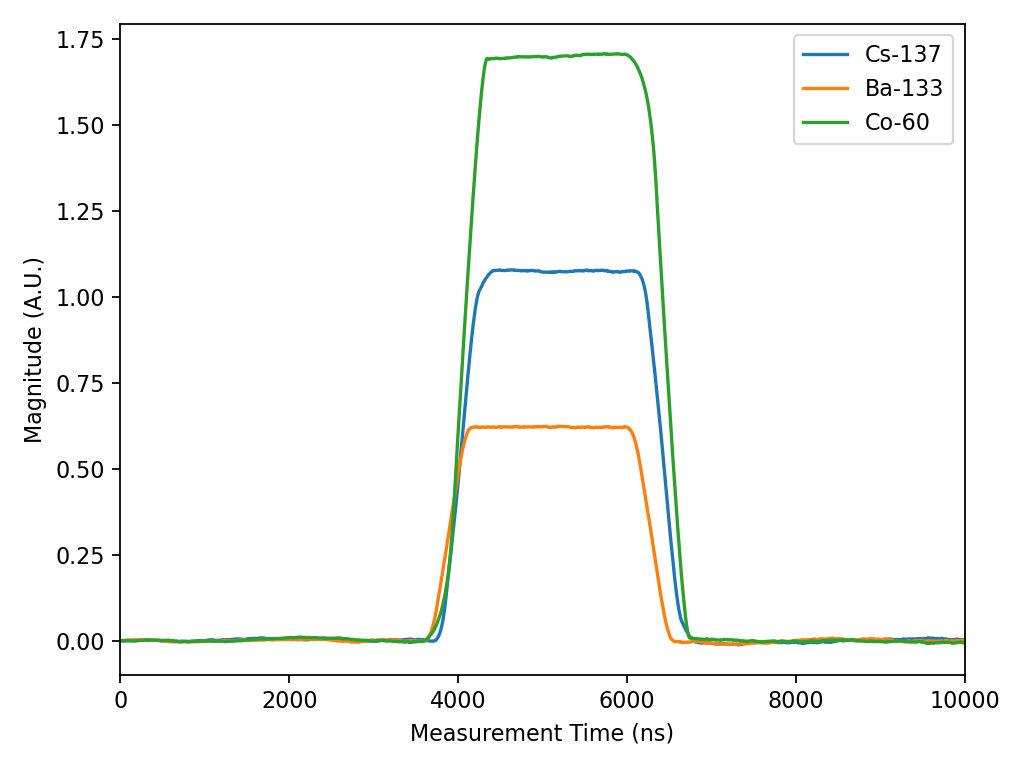

In [493]:
plt.figure()
plt.plot(wave_times,filtered_cs[12],label='Cs-137')
plt.plot(wave_times,filtered_ba[6],label='Ba-133')
plt.plot(wave_times,filtered_co[0],label='Co-60')
plt.xlim(0,10000)
plt.xlabel('Measurement Time (ns)')
plt.ylabel('Magnitude (A.U.)')
#plt.title('Example Trapezoid Filtered Pulses from Individual Source Measurements')
plt.legend()
plt.tight_layout()
plt.savefig('figs/all_sources_trapezoids.png')
plt.show()

# Spectral analysis
## Load data into a spectrum

In [452]:
# load filtered waveforms into 'spectrum'
spec = spectrum(all_filtered_waveforms,bins=2000)

<IPython.core.display.Javascript object>


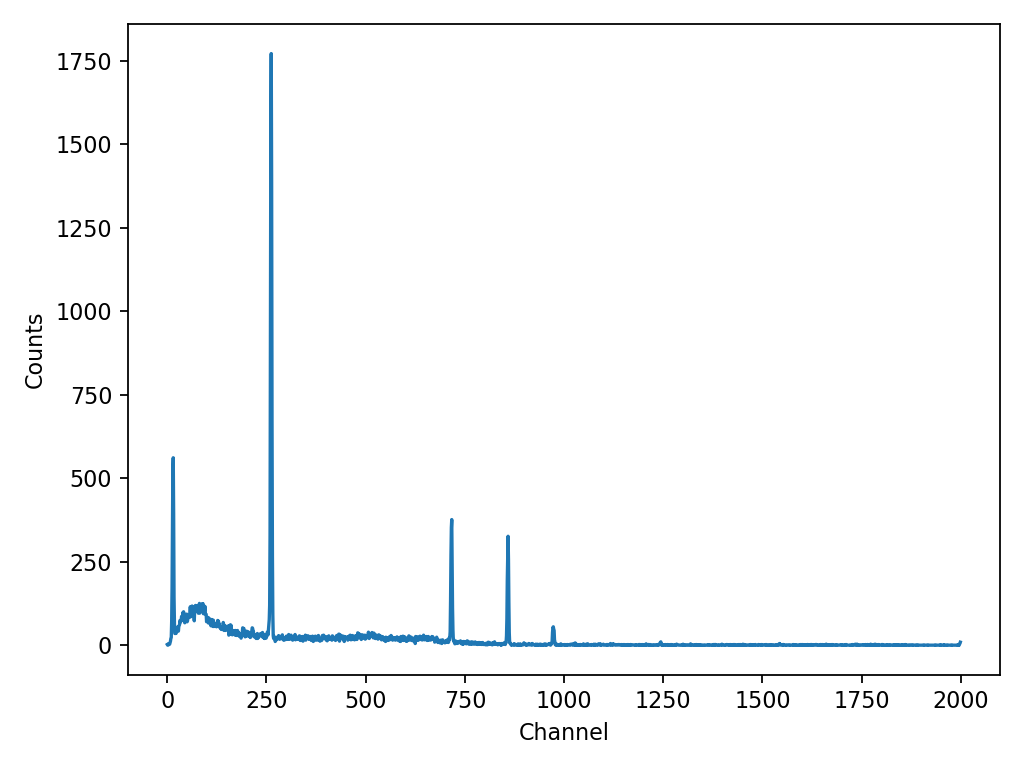

In [453]:
# spectrum histograms trapezoid into a spectrum
spec.plot_spectrum(energy=False,show_calibrated_peaks=False, plot_savefile='figs/channel_spec.png')

## Perform Energy Calibration

Finding Peaks


<IPython.core.display.Javascript object>


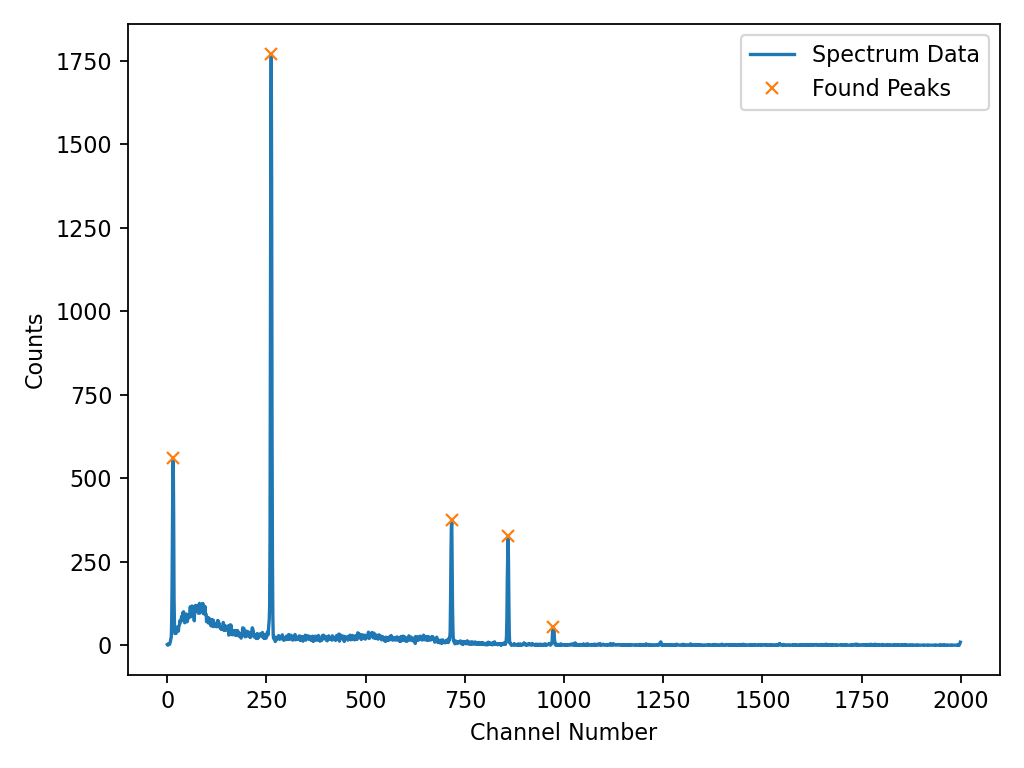

In [454]:
# find gamma peaks
spec.find_gamma_peaks(show_plot=True,prominence=50,width=[0,10],plot_savefile='figs/find_peaks.png')

Fitting gaussian


<IPython.core.display.Javascript object>


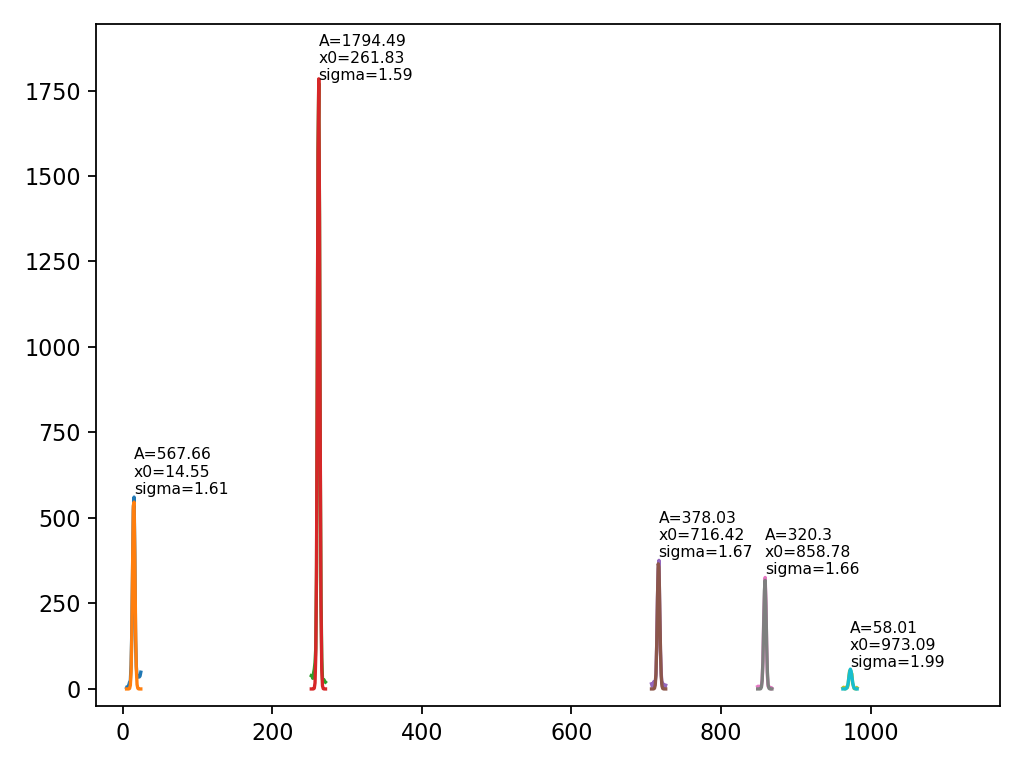

In [455]:
# perform gaussian fit to refine peak positions, find sigma, and counts in peaks
spec.fit_gaussian(show_plot=True,show_fitvalues=True)

In [458]:
# relevant gamma energies
# energies=[356.0129, 661.7,  1173.228, 1332.492]
# compton_edges = np.array([477.,963.,1118.])
# # k40 and tl208
# background_peaks = np.array([1460.820,1764,2614.511])
# possible_pileups = np.array([1173.228+1332.492,662*2,1173.228*2,1332.492*2])

# energies = [356.0129, 661.7,  1173.228, 1332.492, 1460.820]
energies = [383.8485, 661.7,  1173.228, 1332.492, 1460.820]

# provide energies of gamma peaks selected by peak fitting algorithm
spec.find_energy_calibration(energies=energies,alternative='greater')

Finding energy calibration


<IPython.core.display.Javascript object>


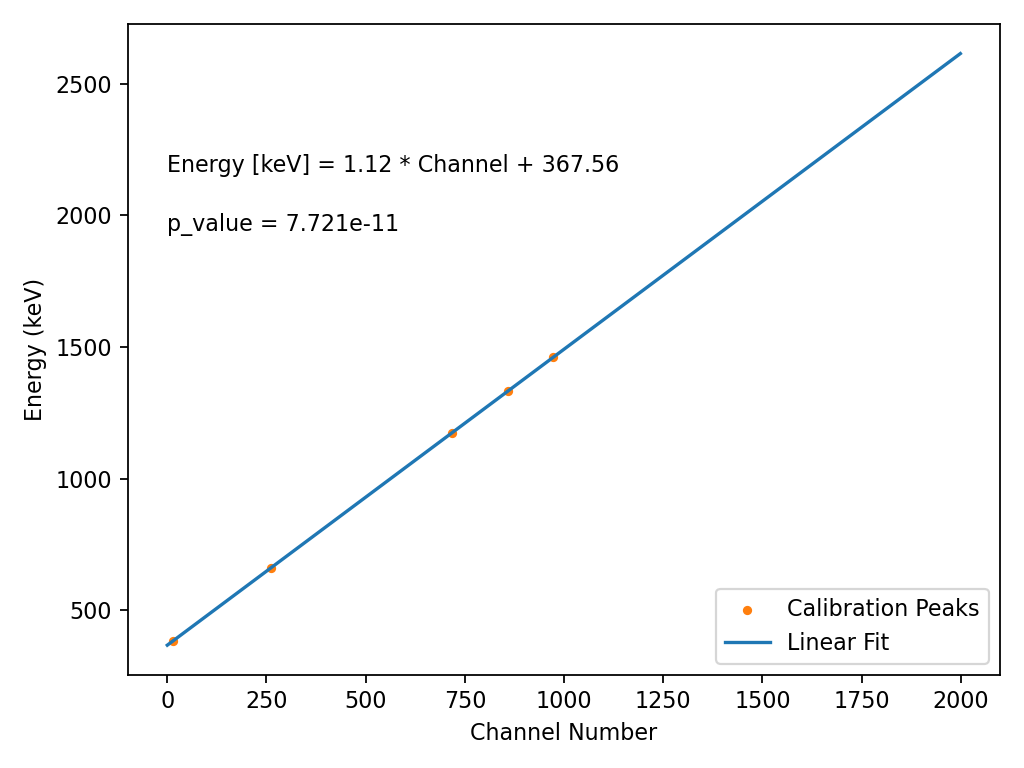

Energy [keV] = 1.12 * Channel + 367.56


In [459]:
# visualize energy calibration
# zoom in for error bars
spec.plot_energy_calibration(show_equation=True,plot_savefile='figs/energy_cal.png')

<IPython.core.display.Javascript object>


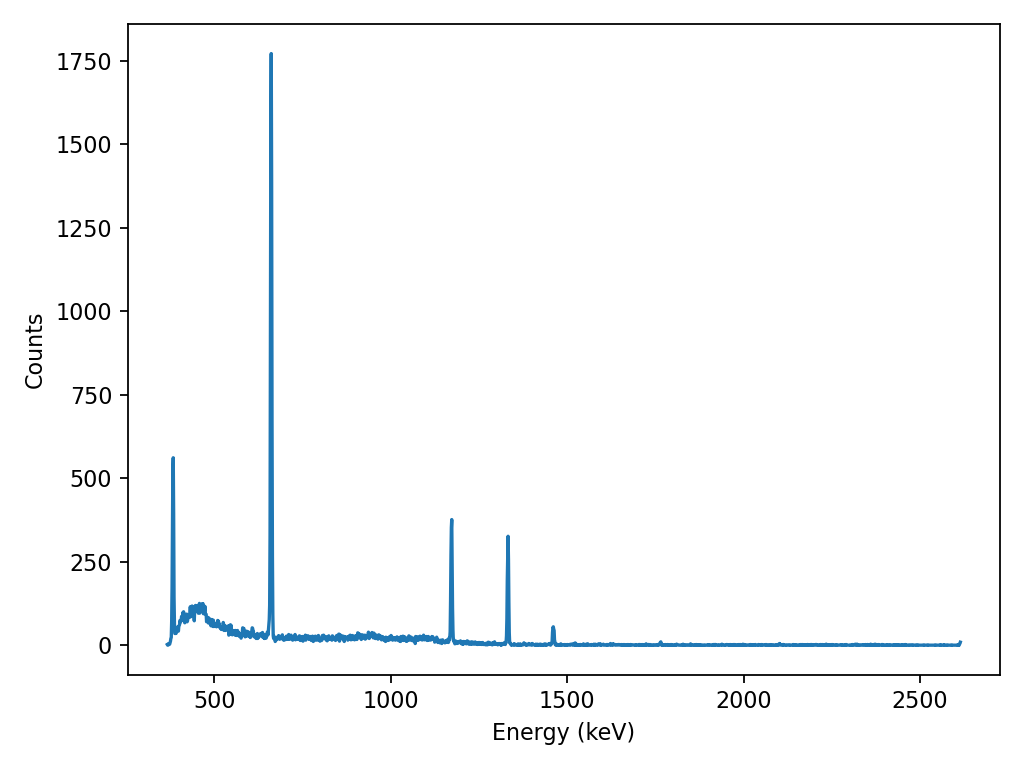

In [460]:
# see spectrum with x-axis as energy
spec.plot_spectrum(show_calibrated_peaks=False,plot_savefile='figs/energy_cal_spectra.png')

In [461]:
# check that expected energies are close to fit energies
fitted_energies = energies
#fitted_energies.append(background_peaks[0])

print(np.isclose(fitted_energies,spec.bin_energies[spec.peaks],atol=5))
fitted_energies - spec.bin_energies[spec.peaks]

[ True  True  True  True  True]


array([-0.56746442, -0.28754363, -0.0756106 , -0.38717435, -0.16913399])

<IPython.core.display.Javascript object>


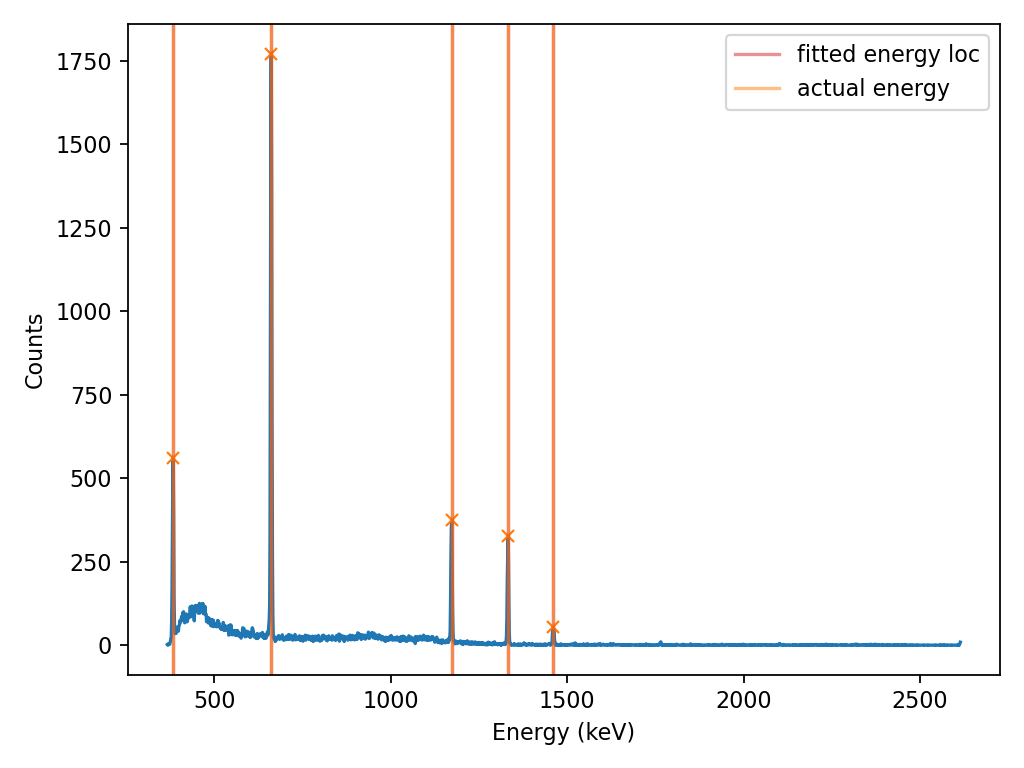

In [462]:
# see deviations from expected energy
# see spectrum with x-axis as energy
spec.plot_spectrum()
plt.axvline(spec.bin_energies[spec.peaks[0]],c='tab:red',alpha=0.5,label='fitted energy loc')
plt.axvline(fitted_energies[0],c='tab:orange',alpha=0.5,label='actual energy')
for i in range(len(spec.peaks)-1):
    plt.axvline(spec.bin_energies[spec.peaks[i+1]],c='tab:red',alpha=0.5)
    plt.axvline(fitted_energies[i+1],c='tab:orange',alpha=0.5)
plt.legend()

<IPython.core.display.Javascript object>


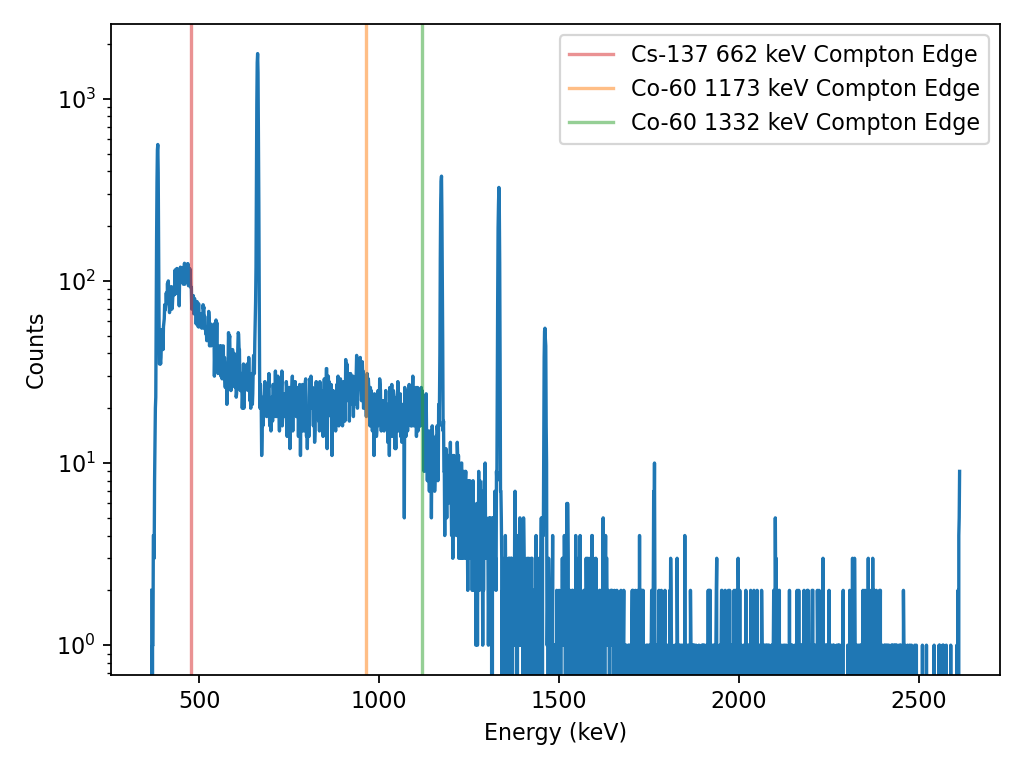

In [463]:
# highlight compton edges
spec.plot_spectrum(semilogy=True,show_calibrated_peaks=False)
plt.axvline(compton_edges[0],c='tab:red',alpha=0.5,label='Cs-137 662 keV Compton Edge')
plt.axvline(compton_edges[1],c='tab:orange',alpha=0.5,label='Co-60 1173 keV Compton Edge')
plt.axvline(compton_edges[2],c='tab:green',alpha=0.5,label='Co-60 1332 keV Compton Edge')
plt.legend()
plt.savefig('figs/spectrum_and_compton_edges.png')
# for i in range(len(compton_edges)):
#     plt.axvline(compton_edges[i],c='tab:red',alpha=0.5,label='Expected Compton Edges')

## Find Energy Resolution of Peaks

<IPython.core.display.Javascript object>


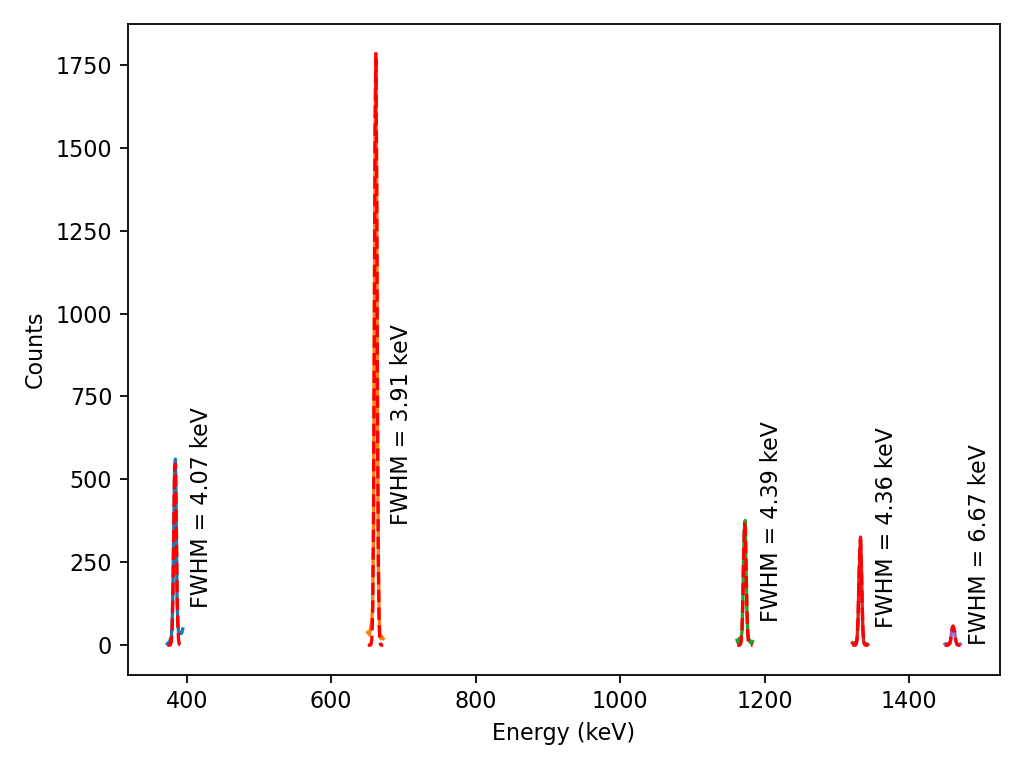

FWHMs = [4.06518889 3.91209526 4.38554584 4.35980873 6.67481928]


In [464]:
# find energy resolution (FWHM of peaks)
spec.find_fwhm(show_plot=True,show_fwhms=True,plot_savefile='figs/find_fwhm.png')
print('FWHMs =',spec.fwhms)

<IPython.core.display.Javascript object>


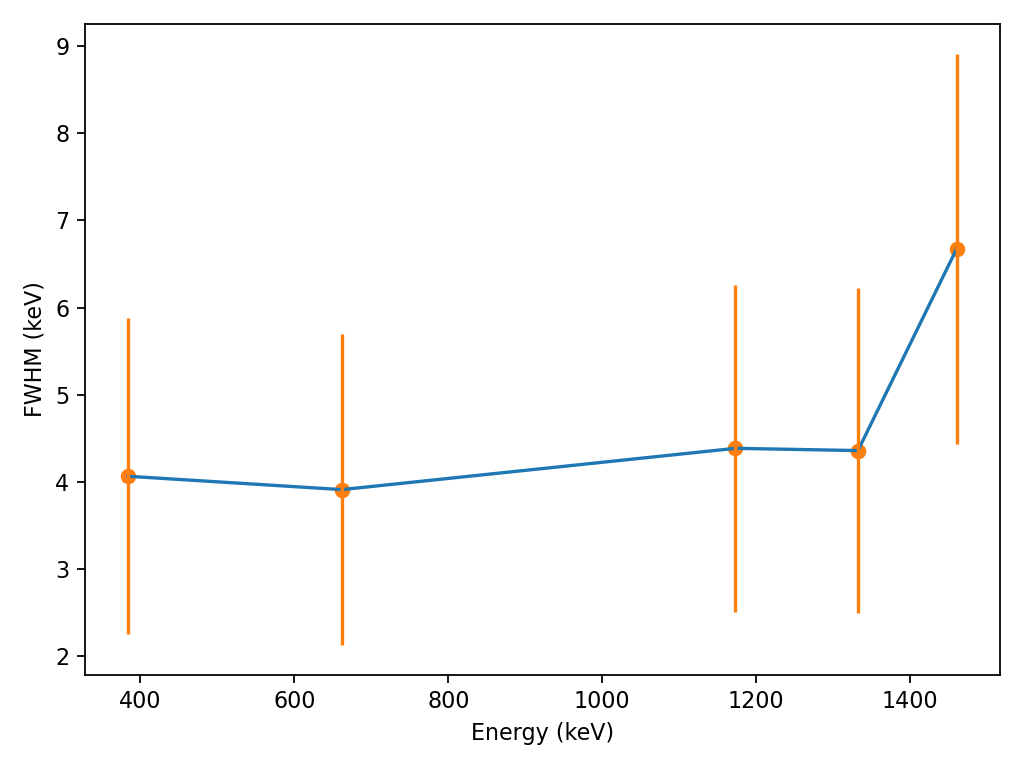

In [465]:
# plot fwhm vs energy
spec.plot_fwhms(plot_savefile='figs/fwhms_vs_energy.png')

In [466]:
# find energy resolution
# E_res = FWHM/Energy
spec.find_energy_resolution()

<IPython.core.display.Javascript object>


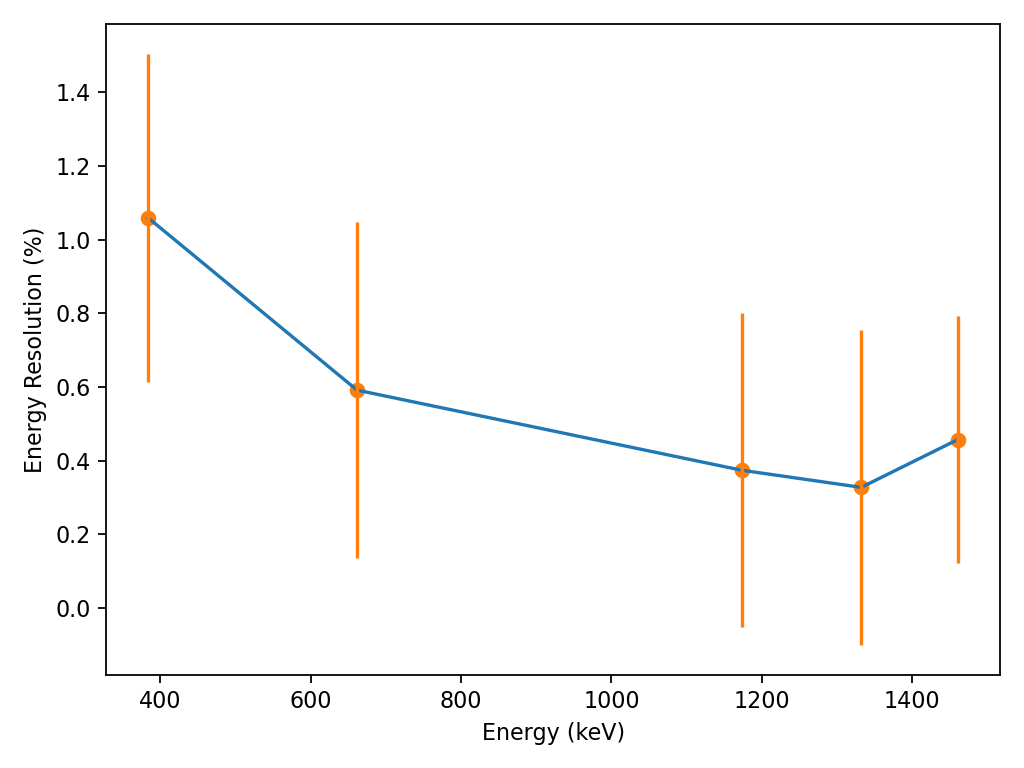

In [467]:
# visualize  FWHMs
spec.plot_energy_resolution(plot_savefile='figs/energy_res_vs_energy.png')
#plt.plot(spec.energies,-np.sqrt(spec.energies))

In [468]:
# find fano factor
# see pulser testing notebook for noise contribution calculation - built into code
spec.find_fano_factor(E_noise = 2.7187219507156715)
print('mean fano factor = ',round(spec.fano_factor.mean(),2),'+/-',round(spec.fano_factor.std(),2))

Finding Fano Factor
mean fano factor =  0.97 +/- 0.43


<IPython.core.display.Javascript object>


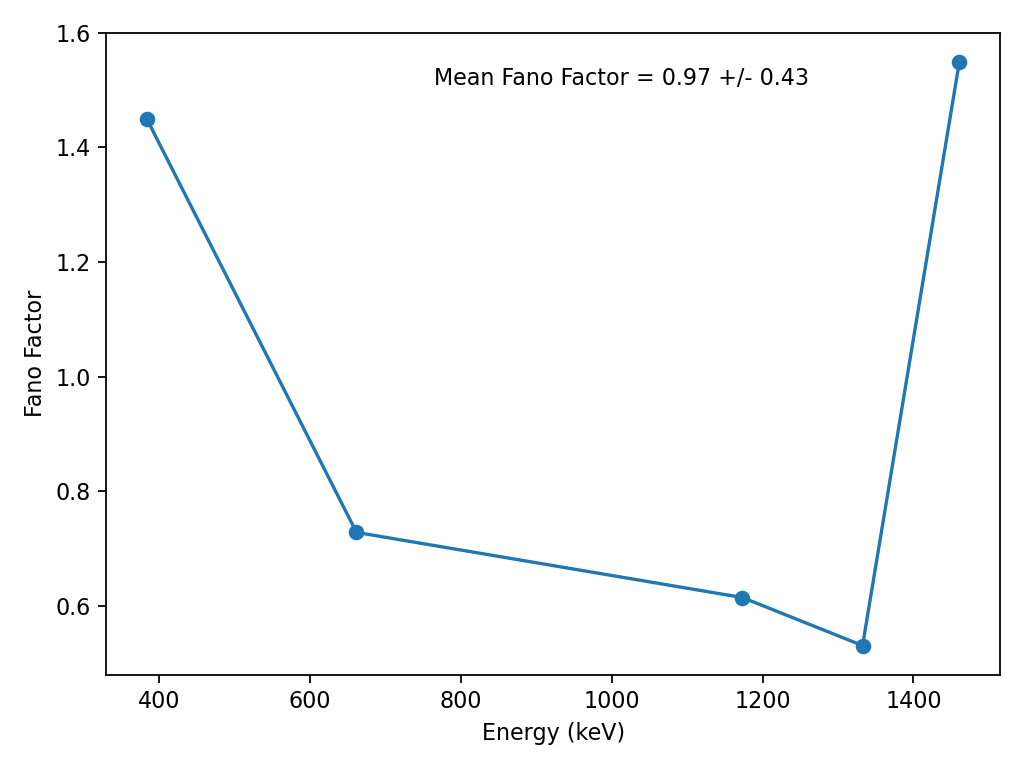

In [469]:
# plot fano factor
spec.plot_fano_factor(display_mean_fano=True,plot_savefile='figs/fano_wbkg.png')

# remove background peak for better looking performance

In [494]:
# IMPORTANT - ONLY RUN THIS CELL !!!!! ONCE !!!!
spec.peaks = np.delete(spec.peaks,4)
spec.energies = np.delete(spec.energies,4)
spec.fwhms = np.delete(spec.fwhms,4)
spec.sigma_E = np.delete(spec.sigma_E,4)

<IPython.core.display.Javascript object>


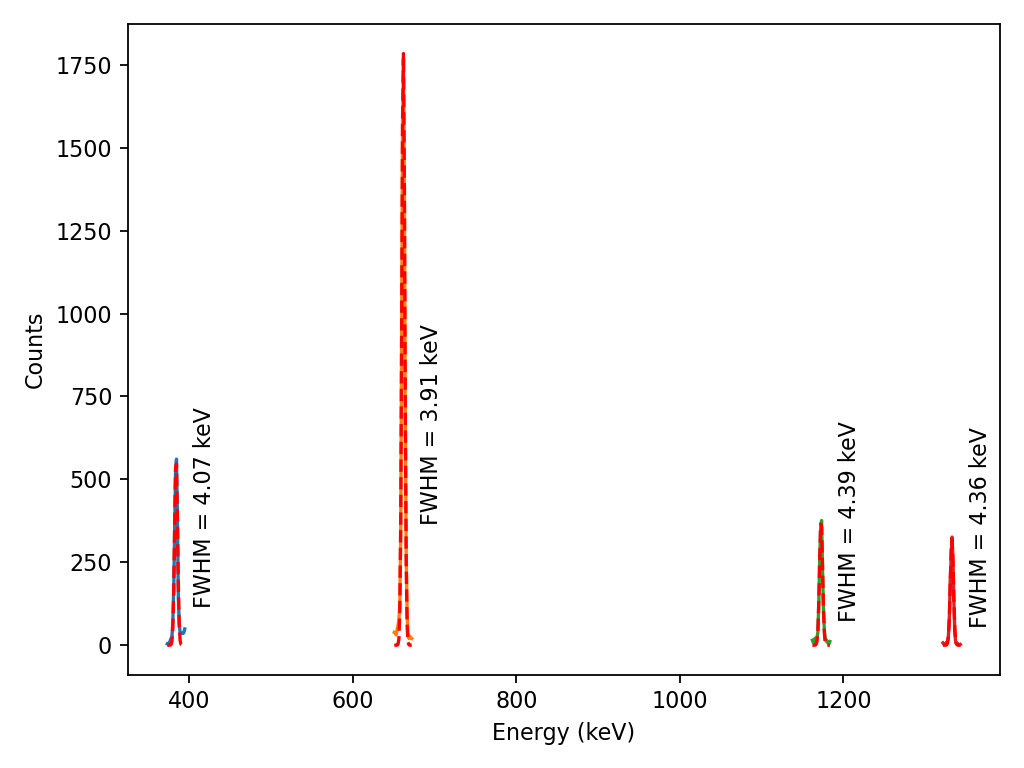

In [496]:
# find energy resolution (FWHM of peaks)
spec.find_fwhm(show_plot=True,show_fwhms=True,plot_savefile='figs/find_fwhm_nobkg.png')

<IPython.core.display.Javascript object>


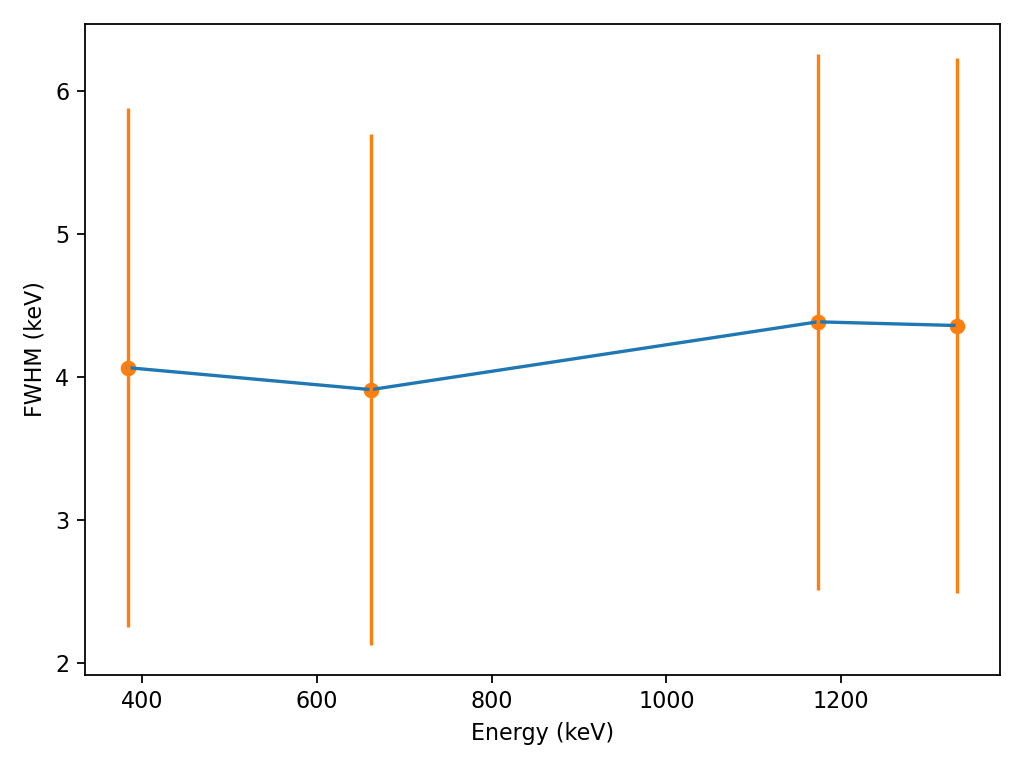

In [443]:
# plot fwhm vs energy
spec.plot_fwhms(plot_savefile='figs/fwhms_vs_energy_nobkg.png')

In [444]:
# find energy resolution (FWHM/E)
spec.find_energy_resolution()

<IPython.core.display.Javascript object>


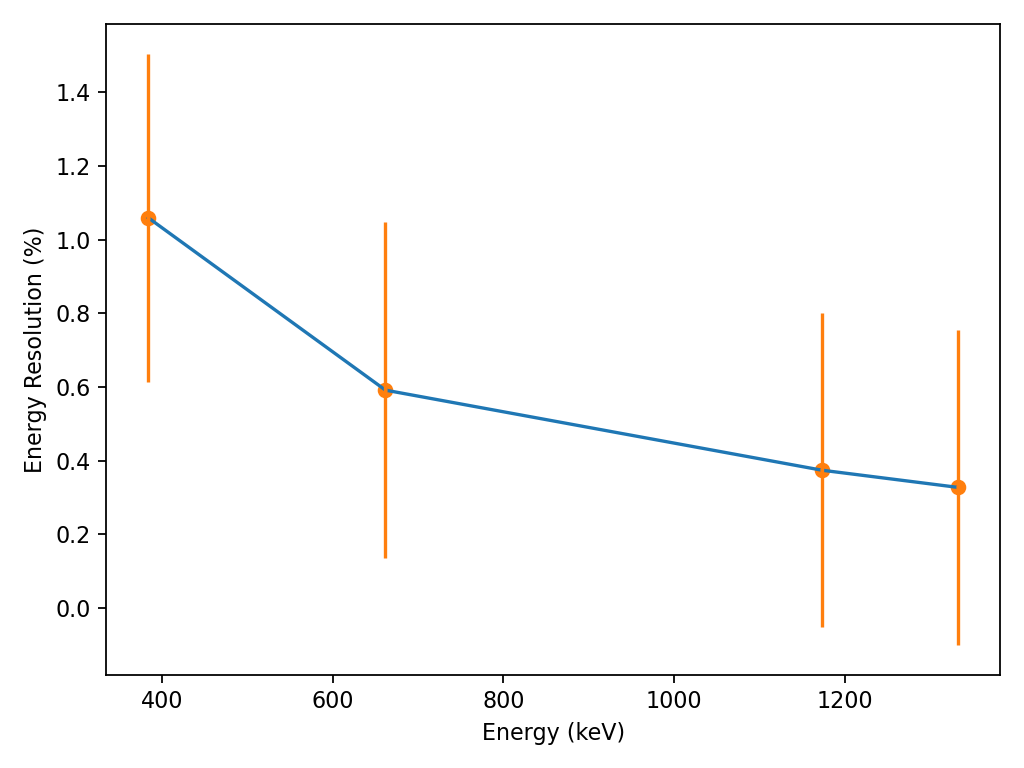

In [445]:
# plot energy resolution
spec.plot_energy_resolution(plot_savefile='figs/eres_nobkg.png')

In [446]:
# find fano factor
spec.find_fano_factor()

Finding Fano Factor


<IPython.core.display.Javascript object>


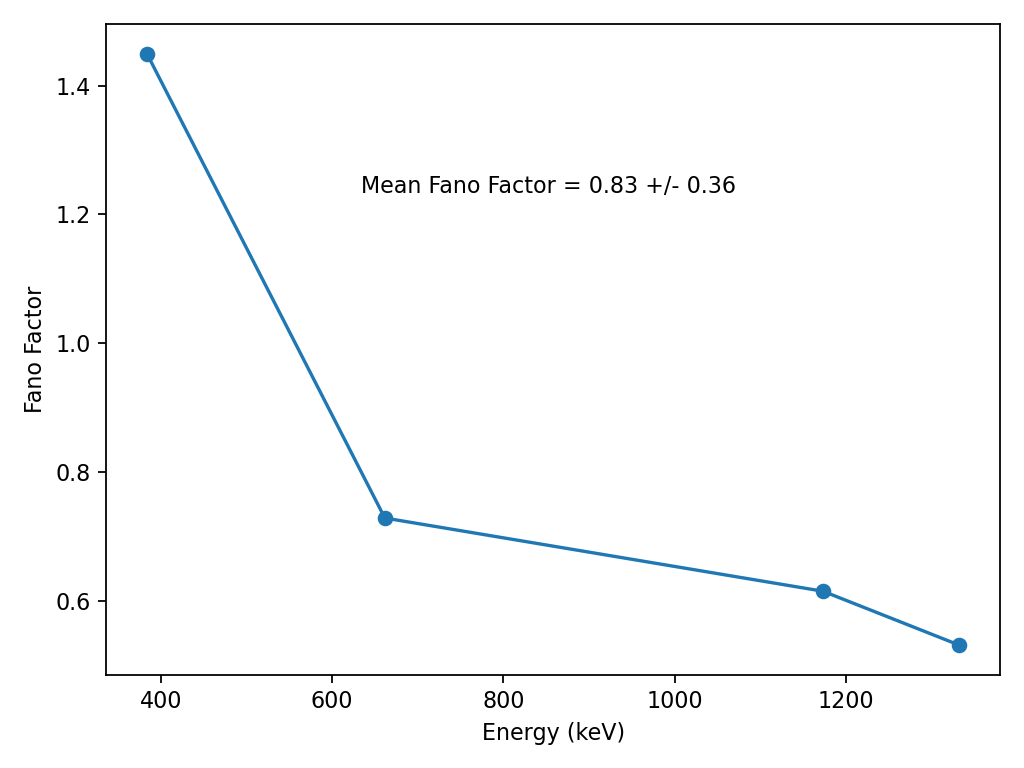

In [447]:
# plot fano factor
spec.plot_fano_factor(plot_savefile='fano_no_bkg.png',display_mean_fano=True)